Exercitiul 1.



/usr/local/lib/python3.12/dist-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rentals     500 non-null    int64  
 1   temp_c      500 non-null    float64
 2   humidity    500 non-null    float64
 3   wind_kph    500 non-null    float64
 4   is_holiday  500 non-null    int64  
 5   season      500 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 23.6+ KB
None


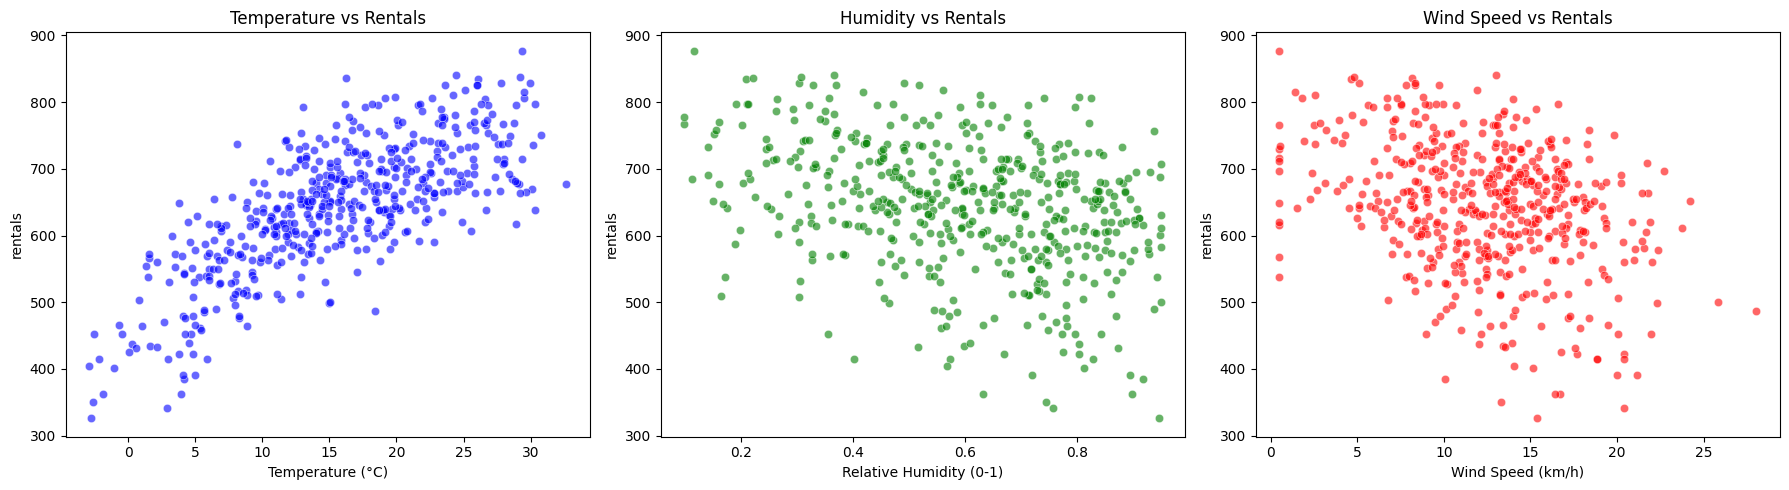

Standardized Predictors (First 5 rows):
 [[-1.01381024 -1.80793953  1.17173491]
 [ 0.15824322 -0.30875769  0.74760237]
 [ 0.20458948  1.37528832  0.18934134]
 [ 0.39088767  0.12835764  1.19239137]
 [ 0.57261101 -1.71385725 -2.4052251 ]]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm


df = pd.read_csv('bike_daily.csv')

print(df.info())

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='temp_c', y='rentals', ax=axes[0], color='blue', alpha=0.6)
axes[0].set_title('Temperature vs Rentals')
axes[0].set_xlabel('Temperature (°C)')

sns.scatterplot(data=df, x='humidity', y='rentals', ax=axes[1], color='green', alpha=0.6)
axes[1].set_title('Humidity vs Rentals')
axes[1].set_xlabel('Relative Humidity (0-1)')

sns.scatterplot(data=df, x='wind_kph', y='rentals', ax=axes[2], color='red', alpha=0.6)
axes[2].set_title('Wind Speed vs Rentals')
axes[2].set_xlabel('Wind Speed (km/h)')

plt.tight_layout()
plt.show()

predictors = ['temp_c', 'humidity', 'wind_kph']

for col in predictors:
    df[f'{col}_std'] = (df[col] - df[col].mean()) / df[col].std()

X_data = df[[f'{c}_std' for c in predictors]].values

y_data = df['rentals'].values

print("Standardized Predictors (First 5 rows):\n", X_data[:5])

Exercitiul 2.

Squared Temp HDI: [-0.190, -0.114]


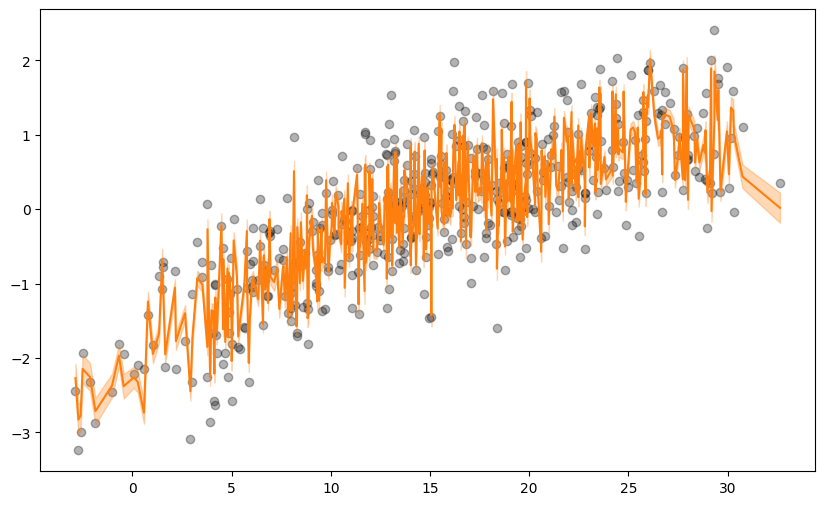

       Predictor      Mean       Low      High
0     temp_c_std  1.227251  0.673379  1.853145
1   humidity_std -1.116008 -1.467247 -0.809105
2   wind_kph_std -1.367116 -1.717192 -1.032957
3     is_holiday -1.594945 -2.212027 -1.015853
4  season_spring  0.091087 -0.674255  0.825199
5  season_summer  1.055675  0.180988  1.898682
6  season_winter -2.397430 -4.328368 -0.701299


In [9]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

df = pd.read_csv('bike_daily.csv')

cols = ['temp_c', 'humidity', 'wind_kph', 'rentals']
for c in cols:
    df[f'{c}_std'] = (df[c] - df[c].mean()) / df[c].std()

season = pd.get_dummies(df['season'], prefix='season', drop_first=True, dtype=int)
df = pd.concat([df, season], axis=1)
df['temp_c_std2'] = df['temp_c_std'] ** 2

feats_lin = ['temp_c_std', 'humidity_std', 'wind_kph_std', 'is_holiday'] + list(season.columns)
feats_poly = feats_lin + ['temp_c_std2']

X_lin = df[feats_lin].values.astype(float)
X_poly = df[feats_poly].values.astype(float)
y_reg = df['rentals_std'].values.astype(float)

with pm.Model() as model_linear:
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 2, shape=X_lin.shape[1])
    s = pm.HalfNormal('s', 2)
    mu = a + pm.math.dot(X_lin, b)
    y = pm.Normal('y', mu, s, observed=y_reg)
    trace_lin = pm.sample(1000, chains=2, cores=1, return_inferencedata=False, progressbar=False)

with pm.Model() as model_poly:
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 2, shape=X_poly.shape[1])
    s = pm.HalfNormal('s', 2)
    mu = a + pm.math.dot(X_poly, b)
    y = pm.Normal('y', mu, s, observed=y_reg)
    trace_poly = pm.sample(1000, chains=2, cores=1, return_inferencedata=False, progressbar=False)

betas = trace_poly.get_values('b')
temp2 = betas[:, -1]
low, high = np.percentile(temp2, [2.5, 97.5])
print(f"Squared Temp HDI: [{low:.3f}, {high:.3f}]")

alphas = trace_poly.get_values('a')
mu_pred = alphas[:, None] + np.dot(betas, X_poly.T)
mu_mean = mu_pred.mean(0)
mu_low = np.percentile(mu_pred, 2.5, 0)
mu_high = np.percentile(mu_pred, 97.5, 0)

idx = np.argsort(df['temp_c'])
plt.figure(figsize=(10, 6))
plt.scatter(df['temp_c'], df['rentals_std'], color='k', alpha=0.3)
plt.plot(df['temp_c'].iloc[idx], mu_mean[idx], color='C1')
plt.fill_between(df['temp_c'].iloc[idx], mu_low[idx], mu_high[idx], color='C1', alpha=0.3)
plt.show()

Q = df['rentals'].quantile(0.75)
y_bin = (df['rentals'] >= Q).astype(int).values

with pm.Model() as model_log:
    a = pm.Normal('a', 0, 2)
    b = pm.Normal('b', 0, 2, shape=X_lin.shape[1])
    p = pm.math.sigmoid(a + pm.math.dot(X_lin, b))
    y = pm.Bernoulli('y', p, observed=y_bin)
    trace_log = pm.sample(1000, chains=2, cores=1, return_inferencedata=False, progressbar=False)

log_b = trace_log.get_values('b')
res = pd.DataFrame({
    'Predictor': feats_lin,
    'Mean': log_b.mean(0),
    'Low': np.percentile(log_b, 2.5, 0),
    'High': np.percentile(log_b, 97.5, 0)
})
print(res)

Exercitiul 3.

In [11]:
print("\n--- Linear Model Posterior Summary ---")
summary_linear = az.summary(trace_linear, var_names=['betas'], kind='stats')
summary_linear['variable_name'] = features_linear
print(summary_linear[['variable_name', 'mean', 'sd', 'hdi_3%', 'hdi_97%']])

print("\n--- Polynomial Model Posterior Summary ---")
summary_poly = az.summary(trace_poly, var_names=['betas'], kind='stats')
summary_poly['variable_name'] = features_poly
print(summary_poly[['variable_name', 'mean', 'sd', 'hdi_3%', 'hdi_97%']])

max_beta_idx = np.abs(summary_poly['mean']).argmax()
print(f"\nMost influential variable in Poly Model: {summary_poly.iloc[max_beta_idx]['variable_name']} (Beta = {summary_poly.iloc[max_beta_idx]['mean']:.3f})")

az.plot_trace(trace_poly, var_names=['betas', 'sigma'])
plt.show()


--- Linear Model Posterior Summary ---


ValueError: Can only convert xarray dataarray, xarray dataset, dict, pytree (if 'dm-tree' is installed), netcdf filename, numpy array, object with __array__, pystan fit, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not MultiTrace

Exercitiul 4.

In [12]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

df = pd.read_csv('bike_daily.csv')

cols_to_std = ['temp_c', 'humidity', 'wind_kph', 'rentals']
for col in cols_to_std:
    df[f'{col}_std'] = (df[col] - df[col].mean()) / df[col].std()

season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True, dtype=int)
df = pd.concat([df, season_dummies], axis=1)
df['temp_c_std2'] = df['temp_c_std'] ** 2

feats_linear = ['temp_c_std', 'humidity_std', 'wind_kph_std', 'is_holiday'] + list(season_dummies.columns)
feats_poly = feats_linear + ['temp_c_std2']

X_linear = df[feats_linear].values.astype(float)
X_poly = df[feats_poly].values.astype(float)
y_data = df['rentals_std'].values.astype(float)

with pm.Model() as m_linear:
    alpha = pm.Normal('alpha', 0, 2)
    beta = pm.Normal('beta', 0, 2, shape=X_linear.shape[1])
    sigma = pm.HalfNormal('sigma', 2)
    mu = alpha + pm.math.dot(X_linear, beta)
    y_obs = pm.Normal('y_obs', mu, sigma, observed=y_data)
    idata_lin = pm.sample(1000, return_inferencedata=True, chains=2, cores=1)

with pm.Model() as m_poly:
    alpha = pm.Normal('alpha', 0, 2)
    beta = pm.Normal('beta', 0, 2, shape=X_poly.shape[1])
    sigma = pm.HalfNormal('sigma', 2)
    mu = alpha + pm.math.dot(X_poly, beta)
    y_obs = pm.Normal('y_obs', mu, sigma, observed=y_data)
    idata_poly = pm.sample(1000, return_inferencedata=True, chains=2, cores=1)

comp = az.compare({'Linear': idata_lin, 'Polynomial': idata_poly}, ic='waic')
print("\nModel Comparison (Lower WAIC is better):")
print(comp)
az.plot_compare(comp)
plt.show()

with m_poly:
    pm.sample_posterior_predictive(idata_poly, extend_inferencedata=True)

plt.figure(figsize=(10, 6))

plt.scatter(df['temp_c'], df['rentals_std'], color='k', alpha=0.5, label='Observed Data')

sort_idx = np.argsort(df['temp_c'])
temp_sorted = df['temp_c'].iloc[sort_idx]
ppc_mean = idata_poly.posterior_predictive['y_obs'].mean(dim=['chain', 'draw'])
ppc_hdi = az.hdi(idata_poly.posterior_predictive['y_obs'])

plt.plot(temp_sorted, ppc_mean[sort_idx], color='C1', label='Posterior Mean')

hdi_low = ppc_hdi['y_obs'][:, 0].values[sort_idx]
hdi_high = ppc_hdi['y_obs'][:, 1].values[sort_idx]
plt.fill_between(temp_sorted, hdi_low, hdi_high, color='C1', alpha=0.3, label='94% HDI')

plt.xlabel("Temperature (°C)")
plt.ylabel("Standardized Rentals")
plt.title("Posterior Predictive Check: Model Fit vs Temperature")
plt.legend()
plt.show()

threshold = df['rentals'].median()
df['is_high_demand'] = (df['rentals'] > threshold).astype(int)

y_binary = df['is_high_demand'].values

print(f"High Demand Threshold: {threshold}")
print(f"Class Balance: {np.mean(y_binary):.2%} High Demand days")

with pm.Model() as m_logistic:
    alpha = pm.Normal('alpha', 0, 2)
    betas = pm.Normal('betas', 0, 2, shape=X_linear.shape[1])

    z = alpha + pm.math.dot(X_linear, betas)

    p = pm.math.sigmoid(z)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_binary)

    idata_log = pm.sample(1000, return_inferencedata=True, chains=2, cores=1)

print("\nLogistic Regression Coefficients (Log-Odds):")
summary = az.summary(idata_log, var_names=['alpha', 'betas'])
summary['predictor'] = ['Intercept'] + feats_linear
print(summary[['predictor', 'mean', 'hdi_3%', 'hdi_97%']])

az.plot_forest(idata_log, var_names=['betas'], combined=True)
plt.title("Impact of Predictors on High Demand Probability")
plt.xlabel("Log-Odds Effect (Positive = Higher Probability)")
plt.show()

Output()

Output()

TypeError: Encountered error in ELPD computation of compare.

Exerictiul 5.

High Demand Threshold (75th percentile): 708.0
Number of High Demand Days: 127 out of 500


Output()


Logistic Regression Posterior Summary:
         predictor_name   mean     sd  hdi_3%  hdi_97%
alpha         Intercept -1.444  0.310  -1.970   -0.828
betas[0]     temp_c_std  1.230  0.296   0.679    1.783
betas[1]   humidity_std -1.115  0.169  -1.425   -0.788
betas[2]   wind_kph_std -1.363  0.187  -1.737   -1.032
betas[3]     is_holiday -1.601  0.312  -2.166   -1.027
betas[4]  season_spring  0.085  0.389  -0.652    0.768
betas[5]  season_summer  1.056  0.448   0.232    1.861
betas[6]  season_winter -2.373  0.909  -4.185   -0.817


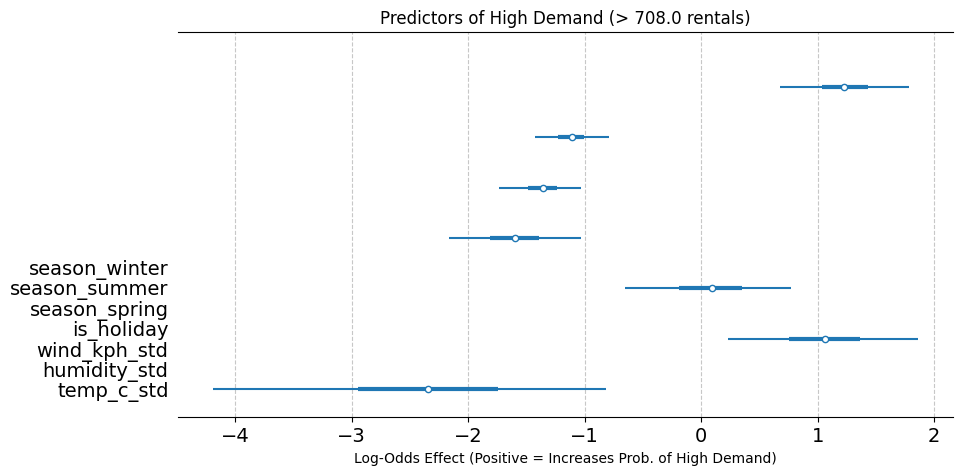

In [5]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

df = pd.read_csv('bike_daily.csv')

Q = df['rentals'].quantile(0.75)
print(f"High Demand Threshold (75th percentile): {Q}")

df['is_high_demand'] = (df['rentals'] >= Q).astype(int)

cols_to_std = ['temp_c', 'humidity', 'wind_kph']
for col in cols_to_std:
    df[f'{col}_std'] = (df[col] - df[col].mean()) / df[col].std()

season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True, dtype=int)
df = pd.concat([df, season_dummies], axis=1)

predictors = ['temp_c_std', 'humidity_std', 'wind_kph_std', 'is_holiday'] + list(season_dummies.columns)

X_data = df[predictors].values.astype(float)
y_data = df['is_high_demand'].values.astype(int)

print(f"Number of High Demand Days: {y_data.sum()} out of {len(y_data)}")

with pm.Model() as logistic_model:
    alpha = pm.Normal('alpha', mu=0, sigma=2)

    betas = pm.Normal('betas', mu=0, sigma=2, shape=X_data.shape[1])

    z = alpha + pm.math.dot(X_data, betas)

    p = pm.math.sigmoid(z)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_data)

    idata_logistic = pm.sample(1000, return_inferencedata=True, chains=2, cores=1)

summary = az.summary(idata_logistic, var_names=['alpha', 'betas'])
summary['predictor_name'] = ['Intercept'] + predictors
print("\nLogistic Regression Posterior Summary:")
print(summary[['predictor_name', 'mean', 'sd', 'hdi_3%', 'hdi_97%']])

az.plot_forest(idata_logistic, var_names=['betas'], combined=True, figsize=(10, 5))
plt.title(f"Predictors of High Demand (> {Q} rentals)")
plt.yticks(ticks=np.arange(len(predictors))[::-1], labels=predictors[::-1])
plt.xlabel("Log-Odds Effect (Positive = Increases Prob. of High Demand)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Exercitiul 6.
Am ales sa pastrez temp_c^2 deoarece relatia bike - temperature rentals nu este liniara

Output()


Posterior Summary (Log-Odds Scale):
              predictor   mean  hdi_3%  hdi_97%
alpha         Intercept -1.448  -2.008   -0.851
betas[0]     temp_c_std  1.226   0.686    1.772
betas[1]   humidity_std -1.113  -1.423   -0.805
betas[2]   wind_kph_std -1.365  -1.713   -1.020
betas[3]     is_holiday -1.597  -2.174   -0.976
betas[4]  season_spring  0.096  -0.617    0.840
betas[5]  season_summer  1.067   0.278    1.911
betas[6]  season_winter -2.383  -4.112   -0.750


<Figure size 1000x600 with 0 Axes>

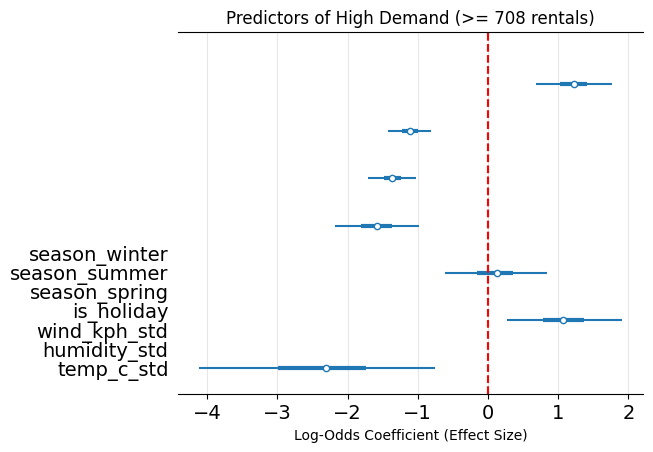

In [6]:
with pm.Model() as logistic_model:
    alpha = pm.Normal('alpha', mu=0, sigma=2)

    betas = pm.Normal('betas', mu=0, sigma=2, shape=X_data.shape[1])

    z = alpha + pm.math.dot(X_data, betas)

    p = pm.math.sigmoid(z)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_data)

    idata_log = pm.sample(1000, tune=1000, chains=2, cores=1, return_inferencedata=True)

summary = az.summary(idata_log, var_names=['alpha', 'betas'])
summary['predictor'] = ['Intercept'] + predictors
print("\nPosterior Summary (Log-Odds Scale):")
print(summary[['predictor', 'mean', 'hdi_3%', 'hdi_97%']])

plt.figure(figsize=(10, 6))
az.plot_forest(idata_log, var_names=['betas'], combined=True)
plt.yticks(ticks=np.arange(len(predictors))[::-1], labels=predictors[::-1])
plt.xlabel("Log-Odds Coefficient (Effect Size)")
plt.title(f"Predictors of High Demand (>= {int(Q)} rentals)")
plt.axvline(0, color='red', linestyle='--')
plt.grid(axis='x', alpha=0.3)
plt.show()

Exercitiul 7

Output()


--- 95% HDI Estimates ---
              predictor   mean  hdi_2.5%  hdi_97.5%
betas[0]     temp_c_std  1.229     0.630      1.805
betas[1]   humidity_std -1.119    -1.432     -0.787
betas[2]   wind_kph_std -1.370    -1.720     -1.010
betas[3]     is_holiday -1.594    -2.198     -0.989
betas[4]  season_spring  0.076    -0.710      0.783
betas[5]  season_summer  1.055     0.208      1.959
betas[6]  season_winter -2.406    -4.193     -0.769

MOST INFLUENTIAL VARIABLE: season_winter
Effect Size (Log-Odds): -2.406
95% HDI: [-4.193, -0.769]


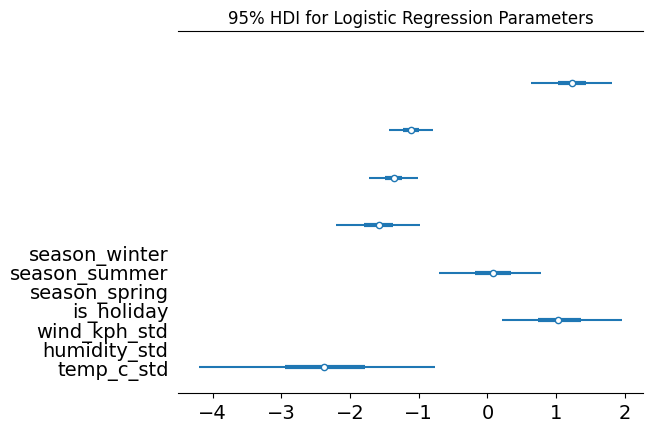

In [7]:
with pm.Model() as logistic_model:
    alpha = pm.Normal('alpha', 0, 2)
    betas = pm.Normal('betas', 0, 2, shape=X_data.shape[1])

    z = alpha + pm.math.dot(X_data, betas)
    p = pm.math.sigmoid(z)

    y_obs = pm.Bernoulli('y_obs', p=p, observed=y_data)

    idata_log = pm.sample(1000, tune=1000, chains=2, cores=1, return_inferencedata=True)

summary = az.summary(idata_log, var_names=['betas'], hdi_prob=0.95)
summary['predictor'] = predictors

print("\n--- 95% HDI Estimates ---")
print(summary[['predictor', 'mean', 'hdi_2.5%', 'hdi_97.5%']])

max_idx = np.abs(summary['mean']).argmax()
best_var = summary.iloc[max_idx]
print(f"\nMOST INFLUENTIAL VARIABLE: {best_var['predictor']}")
print(f"Effect Size (Log-Odds): {best_var['mean']:.3f}")
print(f"95% HDI: [{best_var['hdi_2.5%']:.3f}, {best_var['hdi_97.5%']:.3f}]")

az.plot_forest(idata_log, var_names=['betas'], combined=True, hdi_prob=0.95)
plt.yticks(ticks=np.arange(len(predictors))[::-1], labels=predictors[::-1])
plt.title("95% HDI for Logistic Regression Parameters")
plt.show()